Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training



# Task Statement

Develop models to predict price of used car. We are to train different models with various hyperparameters (You should make at least two different models, but more is better. Remember, various implementations of gradient boosting don't count as different models.) The main point of this step is to compare gradient boosting methods with random forest, decision tree, and linear regression.
Analyze the speed and quality of the models.

# Data description
The dataset is stored in file /datasets/car_data.csv

- Features

    - DateCrawled — date profile was downloaded from the database
    - VehicleType — vehicle body type
    - RegistrationYear — vehicle registration year
    - Gearbox — gearbox type
    - Power — power (hp)
    - Model — vehicle model
    - Mileage — mileage (measured in km due to dataset's regional specifics)
    - RegistrationMonth — vehicle registration month
    - FuelType — fuel type
    - Brand — vehicle brand
    - NotRepaired — vehicle repaired or not
    - DateCreated — date of profile creation
    - NumberOfPictures — number of vehicle pictures
    - PostalCode — postal code of profile owner (user)
    - LastSeen — date of the last activity of the user
- Target

    - Price — price (Euro)

In [3]:

# import pandas and numpy for data preprocessing and manipulation
import numpy as np
import pandas as pd

# matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# import module for splitting and cross-validation using gridsearch
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# import time for time computation
import time

import warnings


# import metric to measure quality of model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

# import modules for preprocessing
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
pd.options.mode.chained_assignment = None # to avoid SettingWithCopyWarning after scaling


# import machine learning models
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression # import linear regression algorithm
from sklearn.ensemble import RandomForestRegressor # import random forest algorithm
from catboost import CatBoostRegressor, Pool # import catboost regressor
from lightgbm import LGBMRegressor # import lightgbm regressor
from xgboost import XGBRegressor

## Data preparation

In [4]:
# read the data

df = pd.read_csv('https://code.s3.yandex.net/datasets/car_data.csv')


In [5]:
# function to determine if columns in file have null values
def get_percent_of_na(df, num):
    count = 0
    df = df.copy()
    s = (df.isna().sum() / df.shape[0])
    for column, percent in zip(s.index, s.values):
        num_of_nulls = df[column].isna().sum()
        if num_of_nulls == 0:
            continue
        else:
            count += 1
        print('Column {} has {:.{}%} percent of Nulls, and {} of nulls'.format(column, percent, num, num_of_nulls))
    if count != 0:
        print("\033[1m" + 'There are {} columns with NA.'.format(count) + "\033[0m")
    else:
        print()
        print("\033[1m" + 'There are no columns with NA.' + "\033[0m")
        

In [6]:
#
def get_info(df):
    """
    This function uses the head(), info(), describe(), shape() and duplicated() 
    methods to display the general information about the dataset.
    """
    print("\033[1m" + '-'*100 + "\033[0m")
    print('Head:')
    print()
    display(df.head())
    print('-'*100)
    print('Info:')
    print()
    display(df.info())
    print('-'*100)
    print('Describe:')
    print()
    display(df.describe())
    print('-'*100)
    display(df.describe(include='object'))
    print()
    print('Columns with nulls:')
    display(get_percent_of_na(df, 2))  # check this out
    print('-'*100)
    print('Shape:')
    print(df.shape)
    print('-'*100)
    print('Duplicated:')
    print("\033[1m" + 'We have {} duplicated rows.\n'.format(df.duplicated().sum()) + "\033[0m")
    print()

In [7]:
# study the general information about the dataset 
print('General information about the dataframe')
get_info(df)

General information about the dataframe
----------------------------------------------------------------------------------------------------
Head:



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCo

None

----------------------------------------------------------------------------------------------------
Describe:



,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


----------------------------------------------------------------------------------------------------


,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,15470,8,2,250,7,40,2,109,18592
top,05/03/2016 14:25,sedan,manual,golf,petrol,volkswagen,no,03/04/2016 00:00,07/04/2016 07:16
freq,66,91457,268251,29232,216352,77013,247161,13719,654



Columns with nulls:
Column VehicleType has 10.58% percent of Nulls, and 37490 of nulls
Column Gearbox has 5.60% percent of Nulls, and 19833 of nulls
Column Model has 5.56% percent of Nulls, and 19705 of nulls
Column FuelType has 9.28% percent of Nulls, and 32895 of nulls
Column NotRepaired has 20.08% percent of Nulls, and 71154 of nulls
There are 5 columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(354369, 16)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 262 duplicated rows.




The data contains 354,369 rows and 16 columns. There are 5 columns with missing values. The missing values in the dataset are mostly missing at random (MAR). In some cases, these missing values are visible error during data compilation, or data omission. Since these columns are important to our model building process, the missing values will be filled. It should be noted that the sonstige_autos brand is missing values not at random (MNAR). There are 262 duplicated rows that have to be dealt with. Convert datatype for some features.

### Preprocessing

In [8]:
# Rename columns
df = df.rename(columns={'DateCrawled': 'date_crawled', 'Price': 'price', 'VehicleType': 'vehicle_type', 'RegistrationYear': 'registration_year', 'Gearbox': 'gearbox',
       'Power': 'power', 'Model': 'model', 'Mileage': 'mileage', 'RegistrationMonth': 'registration_month', 'FuelType': 'fuel_type', 'Brand': 'brand',
       'NotRepaired': 'not_repaired', 'DateCreated': 'date_created', 'NumberOfPictures': 'number_of_pictures', 'PostalCode': 'postal_code', 'LastSeen': 'last_seen'})

# Removing columns not needed for machine learning
df1 = df.copy()
colsRemove = ['date_crawled', 'date_created', 'last_seen','number_of_pictures'] 
df1 = df.drop(colsRemove,axis=1)    
print(df1.isna().sum())
display(df1.head())

price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
mileage                   0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
postal_code               0
dtype: int64


,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,postal_code
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437


In [9]:
# vehicle_type column
print(df1.vehicle_type.isna().sum())

# Converting NaNs in vehicle_type & model columns to 'missing' object.
df1['vehicle_type'] = df1['vehicle_type'].replace (np.nan, 'missing')
df1.isna().sum()

37490


price                     0
vehicle_type              0
registration_year         0
gearbox               19833
power                     0
model                 19705
mileage                   0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
postal_code               0
dtype: int64

In [10]:
# Dropping abnormal values in price 
df1['price'] = np.where((df1['price'] < 100), np.nan, df1['price'])
df1.dropna(subset=['price'], how='any', inplace=True)
print()
print(df1.price.value_counts(dropna=False))

# Replacing not_repaired NaNs
df1['not_repaired'] = df1['not_repaired'].replace (np.nan, 'not_mentioned')






500.0     5670
1500.0    5394
1000.0    4649
1200.0    4594
2500.0    4438
          ... 
7560.0       1
7996.0       1
8751.0       1
776.0        1
706.0        1
Name: price, Length: 3674, dtype: int64


In [11]:
# Gearbox column

df1.dropna(subset=['gearbox'], how='any', inplace=True)
df1.gearbox.isna().sum()

0

In [12]:
# Fueltype column

df1.fuel_type.isna().sum()
df1.dropna(subset=['fuel_type'], how='any', inplace=True)
df1.fuel_type.isna().sum()


0

In [13]:
# Model column 

df1.model.isna().sum()
df1.dropna(subset=['model'], how='any', inplace=True)
df1.model.isna().sum()

0

In [14]:
# Check for more NaNs in the dataset.

print(df1.isna().sum())

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
mileage               0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
postal_code           0
dtype: int64


In [15]:
# Resetting indexes in the  dataset.

df1= df1.reset_index(drop=True)
display(df1)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,postal_code
0,480.0,missing,1993,manual,0,golf,150000,0,petrol,volkswagen,not_mentioned,70435
1,9800.0,suv,2004,auto,163,grand,125000,8,gasoline,jeep,not_mentioned,90480
2,1500.0,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
3,3600.0,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437
4,650.0,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775
...,...,...,...,...,...,...,...,...,...,...,...,...
292185,3200.0,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,96465
292186,1150.0,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,26624
292187,1199.0,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,26135
292188,9200.0,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,87439


In [16]:
# change data to the right type

def change_datatype(df, cols, type_val):
    for col in cols:
        df[col] = df[col].astype(type_val)
        
change_datatype(df, ['date_crawled', 'date_created', 'last_seen'], 'datetime64[ns]')
change_datatype(df, ['price', 'registration_year', 'power', 'registration_month', 'number_of_pictures'], 'int32')

In [17]:
# drop duplicates

n_duplicated = df.duplicated().sum()
df = df.drop_duplicates()
print(f'We handled duplicates by dropping {n_duplicated} duplicated rows giving us {df.shape[0]} total rows in dataset')

We handled duplicates by dropping 262 duplicated rows giving us 354107 total rows in dataset


In [18]:
# Creating encoded dataset.

encoder = LabelEncoder()
df_ordinal = pd.DataFrame(df1, columns=df1.columns)
df_ordinal['vehicle_type'] = encoder.fit_transform(df_ordinal['vehicle_type'])
df_ordinal['gearbox'] = encoder.fit_transform(df_ordinal['gearbox'])
df_ordinal['model'] = encoder.fit_transform(df_ordinal['model'])
df_ordinal['fuel_type'] = encoder.fit_transform(df_ordinal['fuel_type'])
df_ordinal['brand'] = encoder.fit_transform(df_ordinal['brand'])
df_ordinal['not_repaired'] = encoder.fit_transform(df_ordinal['not_repaired'])
display(df_ordinal)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,postal_code
0,480.0,3,1993,1,0,116,150000,0,6,37,1,70435
1,9800.0,7,2004,0,163,117,125000,8,2,14,1,90480
2,1500.0,6,2001,1,75,116,150000,6,6,37,0,91074
3,3600.0,6,2008,1,69,101,90000,7,2,31,0,60437
4,650.0,5,1995,1,102,11,150000,10,6,2,2,33775
...,...,...,...,...,...,...,...,...,...,...,...,...
292185,3200.0,5,2004,1,225,140,150000,5,6,30,2,96465
292186,1150.0,0,2000,1,0,249,150000,3,6,24,0,26624
292187,1199.0,1,2000,0,101,106,125000,3,6,32,0,26135
292188,9200.0,0,1996,1,102,224,150000,3,2,37,0,87439


### Conclusion

The 5 columns had missing values with not_repaired having the most at 20.1% missing values and vehicle_type having 10.6%. The fuel_type, gearbox and model were dropped because they had less than 10% missing values.

All columns renamed with underscores and lowercase letters. The 'date_crawled', 'date_created', 'last_seen','number_of_pictures' columns are not needed for machine learning so they were removed.

The NaN values in the vehicle_type column were replaced with 'missing'. Abnormal values were dropped in the price column. Missing values in the not_repaired column were replaced with 'not mentioned'.

The 'date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', and 'last_seen' columns were removed because they are not needed for machine learning.

Duplicates dropped. Using LabelEncoder, all the categorical features were encoded prior to building the model. The columns encoded were: 'vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand' and 'not_repaired'

## Exploratory Data Analysis

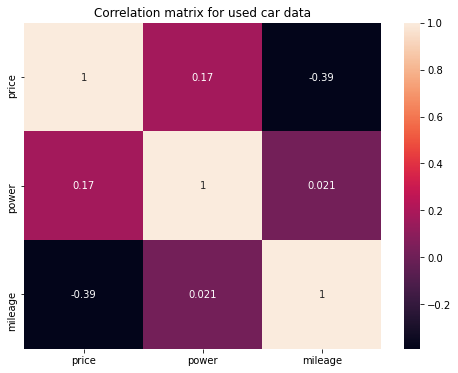

In [19]:
# function to plot correlation matrix for used car data

def corr_matrix(df, label):
    plt.figure(figsize=(8,6))
    corrMatrix = df.corr()
    sns.heatmap(corrMatrix, annot=True)
    plt.title('Correlation matrix for ' + label)
    plt.show()

# correlation matrix
corr_df = df1[['price', 'power', 'mileage']]
corr_matrix(corr_df, 'used car data')

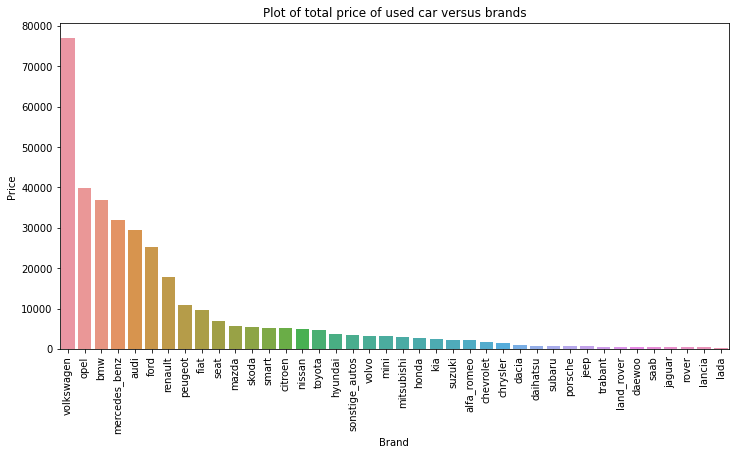

In [20]:
# function to plot seaborn barplot
def plot_snsbar(df, x, y, title):
    xlabel = str(x.replace('_', ' ').capitalize())
    ylabel = str(y.replace('_', ' ').capitalize())
    # create grouped data
    data = df.groupby([x])[y].count().sort_values(ascending=False).reset_index()
    fig, ax=plt.subplots(figsize=(12,6))
    ax = sns.barplot(x = x, y = y, data=data)
    ax.set_title(title, fontdict={'size':12})
    ax.set_ylabel(ylabel, fontsize = 10)
    ax.set_xlabel(xlabel, fontsize = 10)
    ax.set_xticklabels(data[x], rotation=90);

# top selling vehicle brands
plot_snsbar(df, 'brand', 'price', 'Plot of total price of used car versus brands')

### Conclusion

We use the correlation plot (even though it depicts linear correlation amongst variables) to see if any correlation exists amongst some selected variables. We found little or no correlation among those selected variables.

From the visualization done, we can see that the top 10 selling brands in terms of price are volkswagen, opel, bmw, mercedes benz, audi, ford, renault, peugeot, fiat and seat. The most sold vehicle is the sedan and the manual gearbox had the most representation amongst vehicles sold. We have more cars which have not been repaired being represented in the data. Most cars sold either use petrol or gasoline.



## Model training

Train different models with various hyperparameters (You should make at least two different models, but more is better. Remember, various implementations of gradient boosting don't count as different models.) The main point of this step is to compare gradient boosting methods with random forest, decision tree, and linear regression.

### Feature Engineering

In [21]:
# Assigning features and target for the model construction.

features = df_ordinal.drop(['price', 'registration_month', 'postal_code'], axis=1)
target = df_ordinal['price']

# Train test split.
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)


In [22]:
# Creating pipelines.

pipe_dtr = Pipeline([('scaler0', StandardScaler()),
                    ('DecisionTreeRegressor', DecisionTreeRegressor())])

pipe_rfr = Pipeline([('scaler1', StandardScaler()),
                    ('RandomForestRegressor', RandomForestRegressor(n_estimators=100))])

pipe_linear = Pipeline([('scaler2', StandardScaler()),
                       ('LinearRegression(Dummy)', LinearRegression())])

pipe_cat_boost_r = Pipeline([('scaler3', StandardScaler()),
                       ('CatBoostRegressor', CatBoostRegressor(verbose=500))])

pipe_lgbm_r =  Pipeline([('scaler4', StandardScaler()),
                       ('LGBMRegressor', LGBMRegressor())])

pipe_xgb_r = Pipeline([('scaler5', StandardScaler()),
                       ('XGBRegressor', XGBRegressor())])

In [23]:
# Creating list of pipelines.
pipelines = [pipe_dtr, pipe_rfr, pipe_linear, pipe_cat_boost_r, pipe_lgbm_r, pipe_xgb_r]

# Creating a dictionary of pipelines.
pipe_dict = {pipe_dtr: 'DecisionTreeRegressor', pipe_rfr:'RandomForestRegressor', pipe_linear:'LinearRegression',\
             pipe_cat_boost_r: 'CatBoostRegressor', pipe_lgbm_r: 'LGBMRegressor', pipe_xgb_r:'XGBRegressor'}

# Defining a function to calculate RMSE.
def rmse(target,predictions): 
    score = mean_squared_error(target, predictions)
    score = score **0.5
    return score

# Looping trough pipelines to obtain cross validation scores.
rmse = make_scorer(rmse, greater_is_better=False)
for pipe in pipelines:
    print(pipe_dict[pipe])
    print(cross_val_score(pipe, features_train, target_train, scoring = rmse, cv=5))
    print()


DecisionTreeRegressor
[-1988.58898195 -1966.52796247 -1983.04350004 -1976.00371662
 -1965.00303481]

RandomForestRegressor
[-1614.25918953 -1606.91856016 -1625.40039165 -1612.35768011
 -1612.80840786]

LinearRegression
[-3572.32084079 -3610.66573915 -3576.96610722 -3585.62310781
 -3594.48845955]

CatBoostRegressor
Learning rate set to 0.092619
0:	learn: 4327.9371654	total: 70.1ms	remaining: 1m 10s
500:	learn: 1603.2279498	total: 9.05s	remaining: 9.01s
999:	learn: 1523.1841195	total: 17.9s	remaining: 0us
Learning rate set to 0.092619
0:	learn: 4336.1033903	total: 18ms	remaining: 18s
500:	learn: 1598.3615596	total: 9.05s	remaining: 9.02s
999:	learn: 1518.9422365	total: 18.1s	remaining: 0us
Learning rate set to 0.09262
0:	learn: 4341.6722564	total: 17.9ms	remaining: 17.9s
500:	learn: 1594.8323156	total: 9.09s	remaining: 9.05s
999:	learn: 1518.7237856	total: 18s	remaining: 0us
Learning rate set to 0.09262
0:	learn: 4335.3640024	total: 17.9ms	remaining: 17.8s
500:	learn: 1601.8099105	total:

### Hyperparameter Tuning

In [24]:
%%time

# Creating a parameters dictionary for RandomForestRegressor possible hyperparameters values.
parameters = {'n_estimators': (11,15,20,25,40,50),
              'max_depth': (1,6,9),
              } 

# Creating a grid model.
RF_grid = GridSearchCV(RandomForestRegressor(random_state=12345, criterion='mse'), param_grid=parameters, cv=5)
RF_grid_model = RF_grid.fit(features_train, target_train)
print(RF_grid_model.best_estimator_)

RandomForestRegressor(max_depth=9, n_estimators=50, random_state=12345)
CPU times: user 4min 15s, sys: 166 ms, total: 4min 15s
Wall time: 4min 15s


In [25]:
%%time

# Creating a parameters dictionary for  CatBoostRegressor hyperparameters tuning
parameters = {'learning_rate': (0.15,0.5,0.8),
              'depth': (1,5,8),} 

cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

# Creating a grid model.
CB_grid = GridSearchCV(CatBoostRegressor(random_seed=12345), param_grid=parameters, cv=5)
CB_grid_model = CB_grid.fit(features_train, target_train, cat_features = cat_features)
print(CB_grid_model.best_estimator_)

0:	learn: 4366.9623882	total: 31.2ms	remaining: 31.2s
1:	learn: 4188.7988188	total: 60.8ms	remaining: 30.4s
2:	learn: 4051.5497718	total: 80.4ms	remaining: 26.7s
3:	learn: 3922.9453437	total: 99.2ms	remaining: 24.7s
4:	learn: 3814.8614225	total: 118ms	remaining: 23.5s
5:	learn: 3716.6714289	total: 137ms	remaining: 22.8s
6:	learn: 3631.8652496	total: 156ms	remaining: 22.2s
7:	learn: 3553.1352655	total: 183ms	remaining: 22.7s
8:	learn: 3484.9959560	total: 202ms	remaining: 22.3s
9:	learn: 3422.0753997	total: 220ms	remaining: 21.8s
10:	learn: 3370.7448031	total: 240ms	remaining: 21.5s
11:	learn: 3317.6474707	total: 258ms	remaining: 21.3s
12:	learn: 3273.2967148	total: 277ms	remaining: 21s
13:	learn: 3229.0985562	total: 296ms	remaining: 20.9s
14:	learn: 3190.5566742	total: 317ms	remaining: 20.8s
15:	learn: 3153.5437410	total: 336ms	remaining: 20.6s
16:	learn: 3120.7271494	total: 356ms	remaining: 20.6s
17:	learn: 3088.2873879	total: 375ms	remaining: 20.5s
18:	learn: 3058.7393241	total: 401ms

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



178:	learn: 1551.9626408	total: 34.1s	remaining: 2m 36s
179:	learn: 1551.0735538	total: 34.3s	remaining: 2m 36s
180:	learn: 1550.4098177	total: 34.5s	remaining: 2m 36s
181:	learn: 1549.5166931	total: 34.6s	remaining: 2m 35s
182:	learn: 1548.6015449	total: 34.8s	remaining: 2m 35s
183:	learn: 1548.1633586	total: 35s	remaining: 2m 35s
184:	learn: 1547.5615314	total: 35.2s	remaining: 2m 35s
185:	learn: 1546.7445727	total: 35.4s	remaining: 2m 35s
186:	learn: 1546.3249827	total: 35.6s	remaining: 2m 34s
187:	learn: 1545.8383313	total: 35.8s	remaining: 2m 34s
188:	learn: 1545.2269229	total: 36s	remaining: 2m 34s
189:	learn: 1544.5625083	total: 36.1s	remaining: 2m 33s
190:	learn: 1543.7910545	total: 36.3s	remaining: 2m 33s
191:	learn: 1543.0314841	total: 36.5s	remaining: 2m 33s
192:	learn: 1542.3407310	total: 36.6s	remaining: 2m 33s
193:	learn: 1541.9571691	total: 36.8s	remaining: 2m 32s
194:	learn: 1541.5210832	total: 36.9s	remaining: 2m 32s
195:	learn: 1540.8926426	total: 37.1s	remaining: 2m 

In [26]:
print('The best hyperparameters are: {}'.format(CB_grid_model.best_params_))


The best hyperparameters are: {'depth': 8, 'learning_rate': 0.15}


In [27]:
%%time
# Creating a parameters dictionary for LGBMRegressor possible hyperparameters values.
parameters = {'learning_rate': (0.15,0.5,0.8),
              'n_estimators': (3,5,8,10), } 

# Creating a grid model.
LGBM_grid = GridSearchCV(LGBMRegressor(), param_grid=parameters, cv=5) 
LGBM_grid_model = LGBM_grid.fit(features_train, target_train)
print(LGBM_grid_model.best_estimator_)


LGBMRegressor(learning_rate=0.5, n_estimators=10)
CPU times: user 23.5 s, sys: 43.3 ms, total: 23.5 s
Wall time: 23.5 s


In [28]:
%%time
# Creating a parameters dictionary for possible XGBRegressor hyperparameters values.
warnings.simplefilter(action='ignore', category=FutureWarning)

parameters = {'learning_rate': (0.15,0.5,0.65,0.85),
              'n_estimators': (30,35,45,15),} 

# Creating a grid model.
XGB_grid = GridSearchCV(XGBRegressor(), param_grid=parameters, cv=5) 
XGB_grid_model = XGB_grid.fit(features_train, target_train)
print(XGB_grid_model.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=45, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
CPU times: user 6min 58s, sys: 868 ms, total: 6min 59s
Wall time: 7min


### Conclusion

The data was split into training and testing sets. Using pipelines without any parameters, several models were cross validated on the training data.

Linear regression is not very good for hyperparameter tuning, but it is perfect for doing a sanity check of other methods. 

Since LinearRegression does not lend itself to hyperparameters tuning and DecisionTree received an higher CV score then RFR and the neuralnetworks, I decided to not tune those models and went trough with the tuning of my RandomForestRegressor.

## Model analysis

In [29]:
#Creating pipelines with the right hyperparameters setted.

pipe_linear = Pipeline([('scaler0', StandardScaler()),
                       ('LinearRegression', LinearRegression())])

pipe_dtr = Pipeline([('scaler1', StandardScaler()),
                    ('DecisionTreeRegressor', DecisionTreeRegressor())])

pipe_rfr = Pipeline([('scaler2', StandardScaler()),
                    ('RandomForestRegressor', RandomForestRegressor(random_state=12345,max_depth=9,))])

pipe_cat_boost_r = Pipeline([('scaler3', StandardScaler()),
                       ('CatBoostRegressor', CatBoostRegressor(depth=8, learning_rate=0.15))])

pipe_lgbm_r =  Pipeline([('scaler5', StandardScaler()),
                       ('LGBMRegressor', LGBMRegressor(learning_rate=0.8, n_estimators=10))])

pipe_xgb_r = Pipeline([('scaler6', StandardScaler()),
                       ('XGBRegressorQuality', XGBRegressor(learning_rate = 0.5, n_estimators=45))])


In [30]:
%%time
# Saving LinearRegression results on testing dataset.
pipe_linear.fit(features_train, target_train)
predictions = pipe_linear.predict(features_test)
rmse_linear = mean_squared_error(target_test, predictions)**0.5
print('Rmse:',rmse_linear)

Rmse: 3570.322489864276
CPU times: user 63.6 ms, sys: 12 ms, total: 75.6 ms
Wall time: 77.8 ms


In [31]:
%%time
# Saving DecisionTreeRegressor results on testing dataset.
pipe_dtr.fit(features_train, target_train)
predictions = pipe_dtr.predict(features_test)
rmse_dtr = mean_squared_error(target_test, predictions)**0.5

print('Rmse:', rmse_dtr)

Rmse: 1912.2392464782242
CPU times: user 679 ms, sys: 55.8 ms, total: 735 ms
Wall time: 752 ms


In [32]:
%%time
# Saving RandomForestRegressor results on testing dataset.
pipe_rfr.fit(features_train, target_train)
predictions = pipe_rfr.predict(features_test)
rmse_rfr = mean_squared_error(target_test, predictions)**0.5

print('Rmse:', rmse_rfr)



Rmse: 1962.1401500266718
CPU times: user 20.5 s, sys: 28.1 ms, total: 20.6 s
Wall time: 20.6 s


In [33]:
%%time
#Saving LGBMRegressor results on testing dataset.

pipe_lgbm_r.fit(features_train, target_train)
predictions = pipe_lgbm_r.predict(features_test)
rmse_lgbm = mean_squared_error(target_test, predictions)**0.5
print('Rmse:', rmse_lgbm)

Rmse: 1842.1905292205572
CPU times: user 540 ms, sys: 3.97 ms, total: 544 ms
Wall time: 540 ms


In [34]:
%%time
#Saving XGBRegressorFast results on testing dataset.
pipe_xgb_r.fit(features_train, target_train)
predictions = pipe_xgb_r.predict(features_test)
rmse_xgb = mean_squared_error(target_test, predictions)**0.5
print('Rmse:', rmse_xgb)


Rmse: 1657.1101310806484
CPU times: user 9.26 s, sys: 23.8 ms, total: 9.29 s
Wall time: 9.3 s


In [35]:
%%time

#Saving CatBoostRegressor results on testing dataset.
pipe_cat_boost_r.fit(features_train, target_train)
predictions = pipe_cat_boost_r.predict(features_test)
rmse_cat_boost = mean_squared_error(target_test, predictions)**0.5

print('Rmse:', rmse_cat_boost)

0:	learn: 4141.4209388	total: 28.2ms	remaining: 28.2s
1:	learn: 3754.4556585	total: 58.2ms	remaining: 29s
2:	learn: 3432.3674622	total: 87.9ms	remaining: 29.2s
3:	learn: 3171.5953044	total: 116ms	remaining: 28.9s
4:	learn: 2960.9687233	total: 154ms	remaining: 30.6s
5:	learn: 2790.5686150	total: 181ms	remaining: 30.1s
6:	learn: 2649.8764466	total: 208ms	remaining: 29.6s
7:	learn: 2531.9541429	total: 236ms	remaining: 29.3s
8:	learn: 2430.9564156	total: 264ms	remaining: 29s
9:	learn: 2354.1131075	total: 295ms	remaining: 29.2s
10:	learn: 2286.3233714	total: 322ms	remaining: 29s
11:	learn: 2232.9563987	total: 350ms	remaining: 28.8s
12:	learn: 2185.9012553	total: 382ms	remaining: 29s
13:	learn: 2149.4173355	total: 410ms	remaining: 28.9s
14:	learn: 2110.0659224	total: 439ms	remaining: 28.9s
15:	learn: 2070.7967847	total: 470ms	remaining: 28.9s
16:	learn: 2041.4702781	total: 507ms	remaining: 29.3s
17:	learn: 2020.0967087	total: 532ms	remaining: 29s
18:	learn: 1997.2900680	total: 560ms	remainin

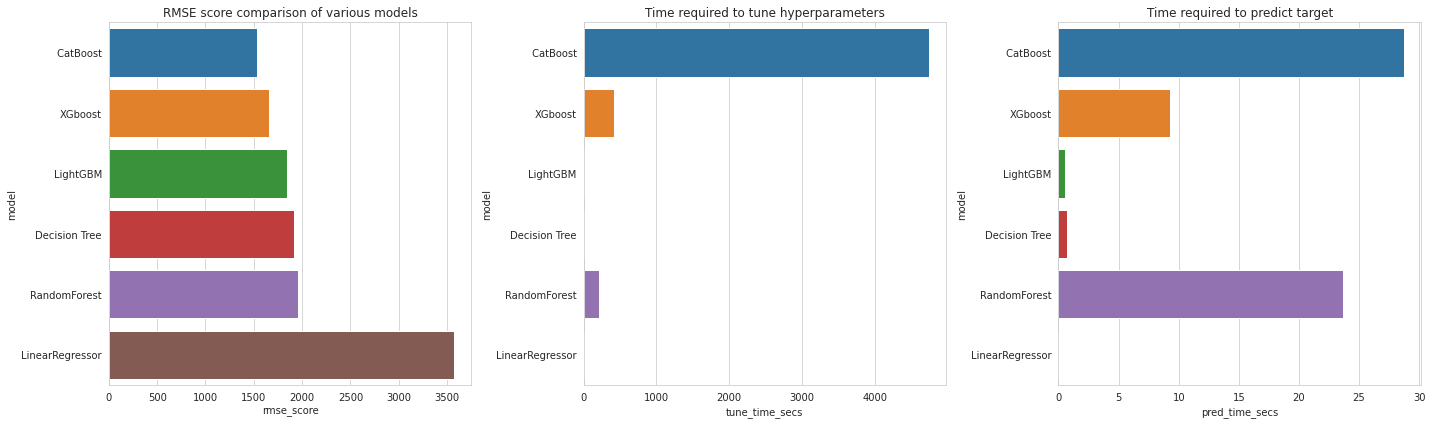

In [40]:
# performance comparison of different models 
model = ['LinearRegressor', 'Decision Tree', 'RandomForest', ' CatBoost', 'XGboost', 'LightGBM']
rmse = [rmse_linear, rmse_dtr, rmse_rfr, rmse_cat_boost, rmse_xgb, rmse_lgbm]
tune_time = [0, 0, 215, 4740, 420, 23.5]
pred_time = [0.077, 0.752, 23.7, 28.7, 9.3, 0.540]

# ceate dataframe
analysis = pd.DataFrame(data = zip(model, rmse, tune_time, pred_time), columns = ['model', 'rmse_score', 'tune_time_secs', 'pred_time_secs'])

# plot performance metrics
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
sns.set_style('whitegrid')
sns.barplot(data = analysis.sort_values('rmse_score'), 
            y= 'model',
            x= 'rmse_score',
            orient= 'h',
            ax=ax[0],
            )
ax[0].set_title('RMSE score comparison of various models')

sns.barplot(data = analysis.sort_values('rmse_score'), 
            y= 'model',
            x= 'tune_time_secs',
            orient= 'h',
            ax=ax[1],
            )
ax[1].set_title('Time required to tune hyperparameters')

sns.barplot(data = analysis.sort_values('rmse_score'), 
            y= 'model',
            x= 'pred_time_secs',
            orient= 'h',
            ax=ax[2],
            )
ax[2].set_title('Time required to predict target')

plt.tight_layout()
plt.show()
 

In [42]:
rmse = [rmse_linear, rmse_dtr, rmse_rfr, rmse_cat_boost, rmse_xgb, rmse_lgbm]
print(rmse)

[3570.322489864276, 1912.2392464782242, 1962.1401500266718, 1531.4155295994701, 1657.1101310806484, 1842.1905292205572]


### Conclusion

From the analysis done, we can see that amongst the different models, Linear regression had the worst score of 3570.32 which is expected whereas Catboost regression had the best score of 1531.41. The LightGBM took less time to tune it hyperparameters. In terms of speed of prediction, the LightGBM took the least time to predict whereas the XGBoost had the most time of prediction.

The RMSE score is a useful way to see how well a model is able to fit a dataset. The larger the RMSE, the larger the difference between the predicted and observed values, which means the worse a model fits the data. Conversely, the smaller the RMSE, the better a model is able to fit the data. It can be particularly useful to compare the RMSE of two different models with each other to see which model fits the data better. From the analysis done, the Catboost had the lowest RMSE score but took the most time to train and predict.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The models have been trained
- [ ]  The analysis of speed and quality of the models has been performed